In [23]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from time import time

import math
import keras
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

#  Prediction of Home Energy Consumption using LSTM

# Household Power Consumption Data Set

In [24]:
df = pd.read_csv('household_power_consumption.txt', delimiter=',')

In [25]:
df = df.iloc[: , 1:]

In [26]:
df.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time
0,4.2160,0.0000,1.0000,17.0000,2006-12-16 17:24:00
1,5.3600,0.0000,1.0000,16.0000,2006-12-16 17:25:00
2,5.3740,0.0000,2.0000,17.0000,2006-12-16 17:26:00
3,5.3880,0.0000,1.0000,17.0000,2006-12-16 17:27:00
4,3.6660,0.0000,1.0000,17.0000,2006-12-16 17:28:00


In [27]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['date_time'] = pd.to_datetime(df['date_time'])
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)

# Electric Consumption of the household

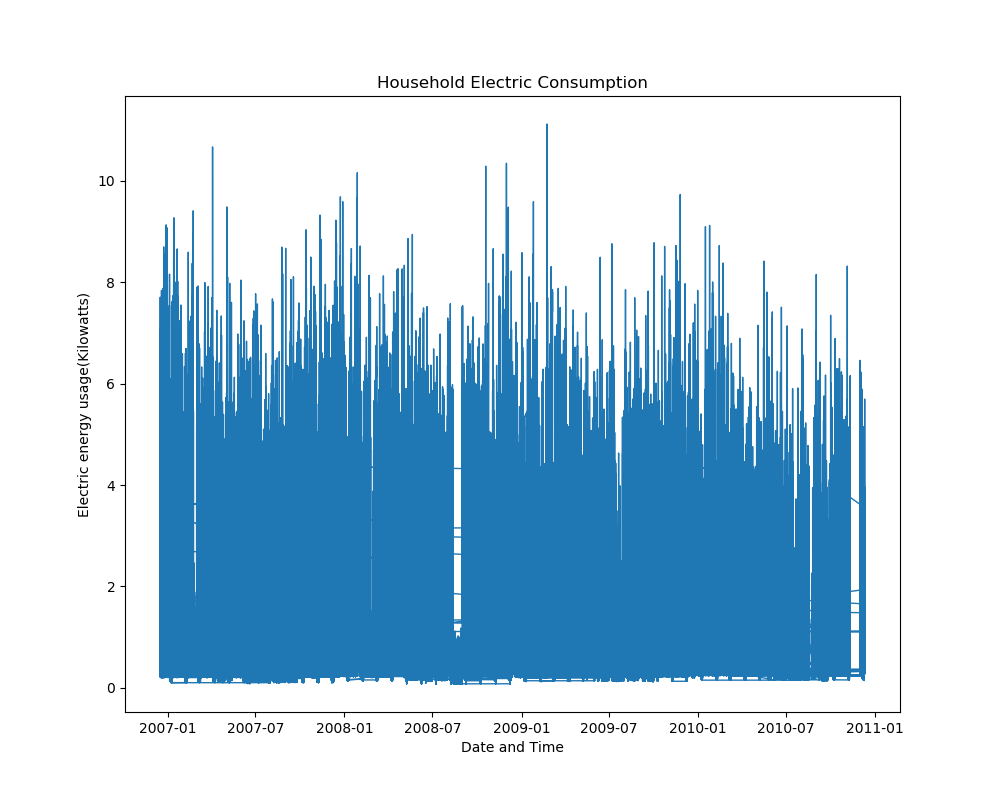

In [28]:
df = df.dropna(subset=['Global_active_power'])
df1 = df.set_index('date_time')
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot()
ax1.plot(df1['Global_active_power'], linewidth=1)
ax1.set_title('Household Electric Consumption')
plt.xlabel("Date and Time")
plt.ylabel("Electric energy usage(Kilowatts)")
ax1.tick_params(axis='both', which='major')

In [29]:
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')
df['Sub_metering_3'] = pd.to_numeric(df['Sub_metering_3'], errors='coerce')

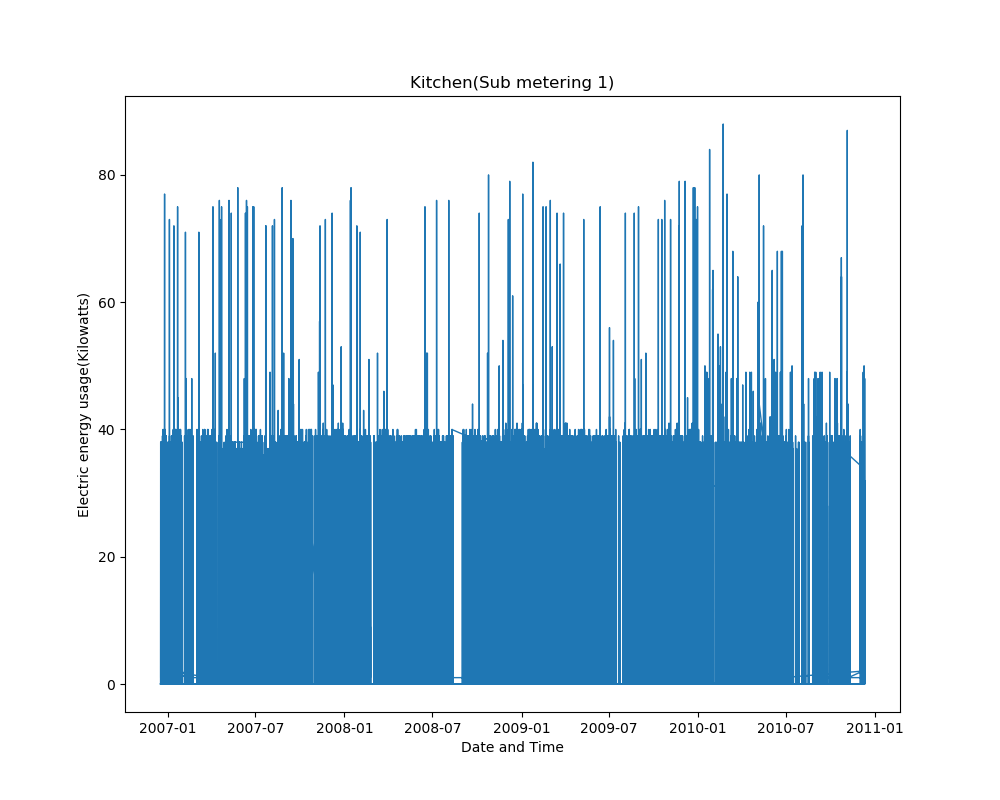

In [30]:
df = df.dropna(subset=['Sub_metering_1'])
df1 = df.set_index('date_time')
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot()
ax1.plot(df1['Sub_metering_1'], linewidth=1)
ax1.set_title('Kitchen(Sub metering 1)')
plt.xlabel("Date and Time")
plt.ylabel("Electric energy usage(Kilowatts)")
ax1.tick_params(axis='both', which='major')

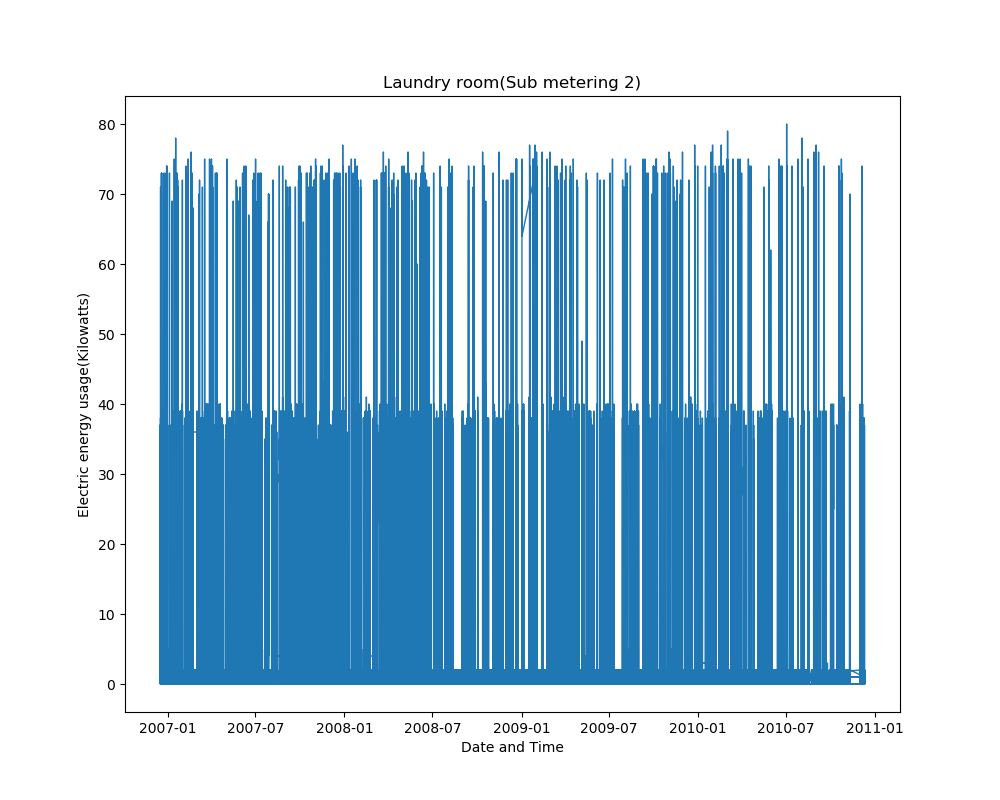

In [31]:
df = df.dropna(subset=['Sub_metering_2'])
df1 = df.set_index('date_time')
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot()
ax1.plot(df1['Sub_metering_2'], linewidth=1)
ax1.set_title('Laundry room(Sub metering 2)')
plt.xlabel("Date and Time")
plt.ylabel("Electric energy usage(Kilowatts)")
ax1.tick_params(axis='both', which='major')

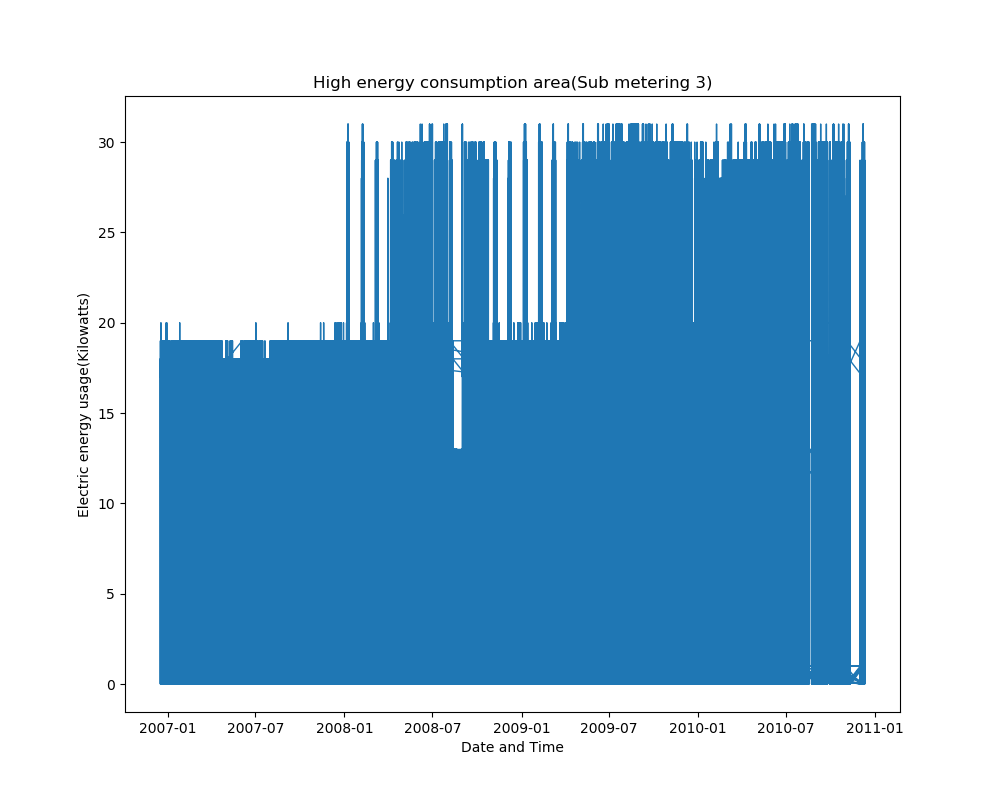

In [32]:
df = df.dropna(subset=['Sub_metering_3'])
df1 = df.set_index('date_time')
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot()
ax1.plot(df1['Sub_metering_3'], linewidth=1)
ax1.set_title('High energy consumption area(Sub metering 3)')
plt.xlabel("Date and Time")
plt.ylabel("Electric energy usage(Kilowatts)")
ax1.tick_params(axis='both', which='major')

In [33]:
df = df.dropna(subset=['Global_active_power'])
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.loc[:,['date_time','Global_active_power','year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)

In [34]:
dataset=df.Global_active_power.values #numpy.ndarray
dataset=dataset.astype('float32')
dataset=np.reshape(dataset, (-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)
train_size=int(len(dataset)*0.80)
test_size=len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [35]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [],[]
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        X.append(a)
        Y.append(dataset[i + look_back,0])
    return np.array(X), np.array(Y)

In [36]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [37]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [38]:
from tensorflow.keras.models import load_model
model = load_model('model1.h5')

# Result of model testing

In [39]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.10249128664075233
Train Root Mean Squared Error: 0.26232085275848543
Test Mean Absolute Error: 0.08763601024797806
Test Root Mean Squared Error: 0.21915656306563205


# Prediction for the next 100 minutes

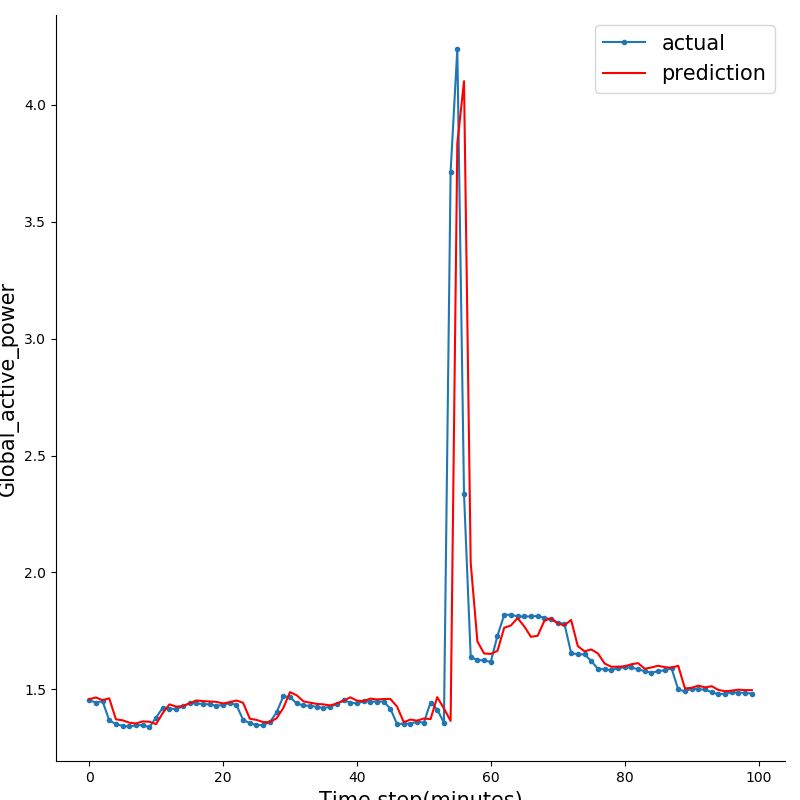

In [40]:
#Compare actual and predict Global_active_power attribute for a 100 minutes 
aa=[x for x in range(100)]
plt.figure(figsize=(8,8))
plt.plot(aa, Y_test[0][:100], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:100], 'r', label="prediction")
# plt.tick_params(Left=False, Labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step(minutes)', size=15)
plt.legend(fontsize=15)
plt.show();

The prediction of total electric energy usage for the next 100 minutes(kilowatts)

In [41]:
i = 0
sum = 0
while i < 100:
    sum = sum + test_predict[i]
    i = i + 1
    
print(sum)

[156.69838]


# Prediction for the next 1000 minutes

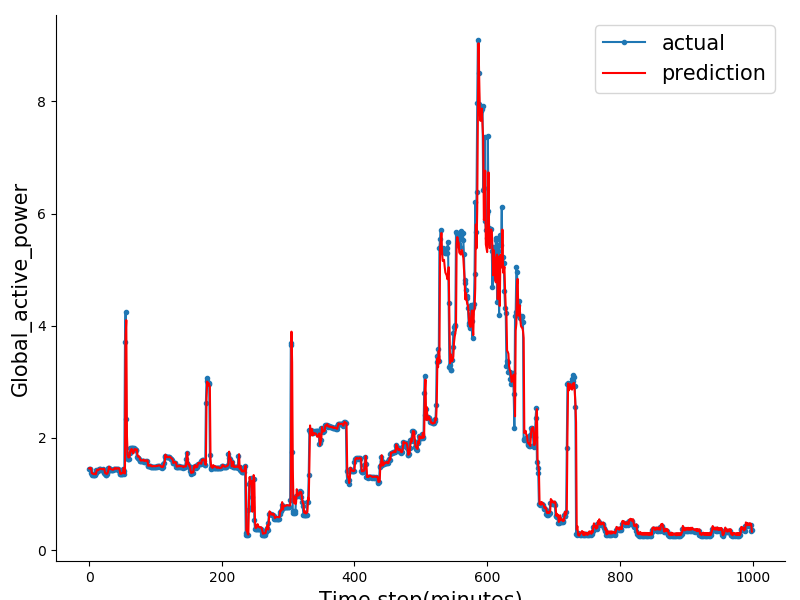

In [42]:
#Compare actual and predict Global_active_power attribute for a 1000 minutes 
aa=[x for x in range(1000)]
plt.figure(figsize=(8,6))
plt.plot(aa, Y_test[0][:1000], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:1000], 'r', label="prediction")
# plt.tick_params(Left=False, Labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step(minutes)', size=15)
plt.legend(fontsize=15)
plt.show();

The prediction of total electric energy usage for the next 1000 minutes(kilowatts)

In [43]:
i = 0
sum = 0
while i < 1000:
    sum = sum + test_predict[i]
    i = i + 1
    
print(sum)

[1646.0916]
